# Connect with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Classes

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]


# Input Data Sample

Imput Pickled Data
--

In [ ]:
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/X_2.pickle", "rb")
X = pickle.load(pickle_in)
 
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/Y_2.pickle", "rb")
Y = pickle.load(pickle_in)

In [ ]:
print('Data: ', len(X), len(Y))

Data:  9596 9596


Split Data into Train, Test and Validation Sets
--

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #20% data as test and validation data

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=1) #10% data as test and 10% as validation data

In [ ]:
print('Train:', len(X_train), len(Y_train), '\nTest: ', len(X_test), len(Y_test), '\nValidation: ', len(X_val), len(Y_val))

Train: 7676 7676 
Test:  960 960 
Validation:  960 960


Sample Data - Train Dataset
--

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


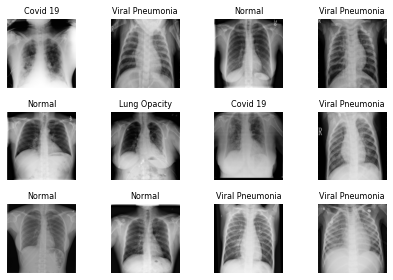

In [ ]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title[:-2], fontsize=8)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

images = {str(Classes[Y_train[i]])+format(str(i).zfill(2)): X_train[i] for i in range(12)}

display_multiple_img(images, 3, 4)

# Model Uses for Classification (ResNet50)

In [ ]:
model = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Add Top Layers
--

In [ ]:
inputs = model.layers[0].input

add_layer = model.layers[-1].output
add_layer = layers.Dense(128)(add_layer)
add_layer = layers.Activation('relu')(add_layer)
add_layer = layers.Dense(64)(add_layer)
add_layer = layers.Activation('relu')(add_layer)
add_layer = layers.GlobalAveragePooling2D()(add_layer)
outputs = layers.Dense(4, activation='softmax')(add_layer)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Train the model
--

In [ ]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 15
model_records = model.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/15
80/80 [==============================] - 3061s 38s/step - loss: 0.4082 - accuracy: 0.8501 - val_loss: 1.8007 - val_accuracy: 0.2552

Epoch 00001: val_accuracy improved from -inf to 0.25521, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-01-performance-0.26-1.80.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_loss improved from inf to 1.80068, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-01-performance-0.26-1.80.hdf5
Epoch 2/15
80/80 [==============================] - 2938s 37s/step - loss: 0.1998 - accuracy: 0.9280 - val_loss: 1.7140 - val_accuracy: 0.2552

Epoch 00002: val_accuracy did not improve from 0.25521

Epoch 00002: val_loss improved from 1.80068 to 1.71396, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-02-performance-0.26-1.71.hdf5
Epoch 3/15
80/80 [==============================] - 3384s 42s/step - loss: 0.1380 - accuracy: 0.9518 - val_loss: 8.6566 - val_accuracy: 0.2552

Epoch 00003: val_accuracy did not improve from 0.25521

Epoch 00003: val_loss did not improve from 1.71396
Epoch 4/15
80/80 [==============================] - 3461s 43s/step - loss: 0.1006 - accuracy: 0.9635 - val_loss: 3.6735 - val_accuracy: 0.2552

Re-Training (Inturrupted Training/Poor Performance)
--

In [ ]:
re_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-10-performance-0.58-2.58.hdf5')

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 15
model_records = re_model.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/15
80/80 [==============================] - 3068s 38s/step - loss: 0.0315 - accuracy: 0.9885 - val_loss: 1.2233 - val_accuracy: 0.6958

Epoch 00001: val_accuracy improved from -inf to 0.69583, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-01-performance-0.70-1.22.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_loss improved from inf to 1.22333, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-01-performance-0.70-1.22.hdf5
Epoch 2/15
80/80 [==============================] - 3008s 38s/step - loss: 0.0538 - accuracy: 0.9808 - val_loss: 0.8918 - val_accuracy: 0.7865

Epoch 00002: val_accuracy improved from 0.69583 to 0.78646, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-02-performance-0.79-0.89.hdf5

Epoch 00002: val_loss improved from 1.22333 to 0.89185, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-02-performance-0.79-0.89.hdf5
Epoch 3/15
80/80 [==============================] - 3021s 38s/step - loss: 0.0229 - accuracy: 0.9905 - val_loss: 0.3762 - val_accuracy: 0.8948

Epoch 00003: val_accuracy improved from 0.78646 to 0.89479, saving model to /content/d

In [ ]:
re_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v2-05-performance-0.90-0.53.hdf5')

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 15
model_records = re_model1.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/15
80/80 [==============================] - 2769s 35s/step - loss: 0.0465 - accuracy: 0.9854 - val_loss: 2.6215 - val_accuracy: 0.4615

Epoch 00001: val_accuracy improved from -inf to 0.46146, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-01-performance-0.46-2.62.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_loss improved from inf to 2.62147, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-01-performance-0.46-2.62.hdf5
Epoch 2/15
80/80 [==============================] - 2761s 35s/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.9874 - val_accuracy: 0.7521

Epoch 00002: val_accuracy improved from 0.46146 to 0.75208, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-02-performance-0.75-0.99.hdf5

Epoch 00002: val_loss improved from 2.62147 to 0.98745, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-02-performance-0.75-0.99.hdf5
Epoch 3/15
80/80 [==============================] - 2765s 35s/step - loss: 0.0150 - accuracy: 0.9948 - val_loss: 0.6674 - val_accuracy: 0.8542

Epoch 00003: val_accuracy improved from 0.75208 to 0.85417, saving model to /content/d

In [ ]:
re_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-05-performance-0.92-0.36.hdf5')

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v4-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_loss = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 15
model_records = re_model2.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/15
80/80 [==============================] - 2813s 35s/step - loss: 0.0337 - accuracy: 0.9885 - val_loss: 5.9260 - val_accuracy: 0.5760

Epoch 00001: val_accuracy improved from -inf to 0.57604, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v4-01-performance-0.58-5.93.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



Epoch 00001: val_loss improved from inf to 5.92601, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v4-01-performance-0.58-5.93.hdf5
Epoch 2/15
80/80 [==============================] - 2792s 35s/step - loss: 0.0301 - accuracy: 0.9889 - val_loss: 5.3827 - val_accuracy: 0.6135

Epoch 00002: val_accuracy improved from 0.57604 to 0.61354, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v4-02-performance-0.61-5.38.hdf5

Epoch 00002: val_loss improved from 5.92601 to 5.38268, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v4-02-performance-0.61-5.38.hdf5
Epoch 3/15
80/80 [==============================] - 2808s 35s/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.4074 - val_accuracy: 0.8875

Epoch 00003: val_accuracy improved from 0.61354 to 0.88750, saving model to /content/d

Learning Visualization
--

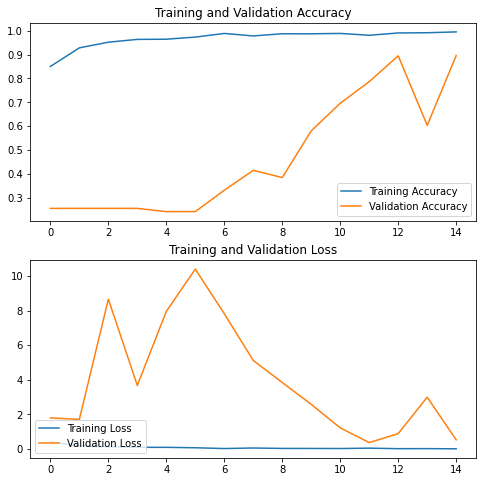

In [ ]:

#Takes values of accuracies and losses manually if inturrupted
train_acc = [0.8501, 0.9280, 0.9518, 0.9635, 0.9643, 0.9732, 0.9884, 0.9780, 0.9872, 0.9870, 0.9885, 0.9808, 0.9905, 0.9914, 0.9949]
val_acc = [0.2552, 0.2552, 0.2552, 0.2552, 0.2417, 0.2417, 0.3313, 0.4146, 0.3844, 0.5802, 0.6958, 0.7865, 0.8948, 0.6031, 0.8958]

train_loss = [0.4082, 0.1998, 0.1380, 0.1006, 0.1010, 0.0759, 0.0309, 0.0618, 0.0382, 0.0361, 0.0315, 0.0538, 0.0229, 0.0265, 0.0152]
val_loss = [1.8007, 1.7140, 8.6566, 3.6735, 7.9510, 10.3913, 7.8162, 5.1173, 3.8437, 2.5822, 1.2233, 0.3762, 0.8918, 2.9944, 0.5326]

#Performance values if not inturrupted
#train_acc = model_records.history['accuracy']
#val_acc = model_records.history['val_accuracy']

#train_loss = model_records.history['loss']
#val_loss = model_records.history['val_loss']

epochs_range = range(15) #epoch = number of trainning epochs

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

## Performance on Test Data

Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Load Model
--

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-05-performance-0.92-0.36.hdf5')

Evaluate Model
--

In [ ]:
new_records = new_model.evaluate(X_test, Y_test)

30/30 [==============================] - 79s 3s/step - loss: 0.3167 - accuracy: 0.9344


Prediction on Unseen X-ray
--

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

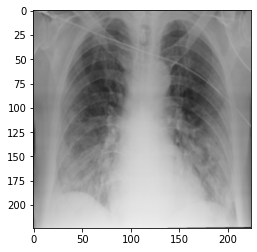

In [ ]:
img_size = 224
path = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Covid 19/COVID-1253.png'
data_img= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(data_img, cv2.COLOR_GRAY2RGB)
data_img = cv2.resize(backtorgb, (img_size, img_size))

plt.imshow(data_img)

data_img = np.array(data_img).reshape(-1, img_size, img_size, 3) 
data_img = (data_img/255.0).astype(np.float32)

In [ ]:
predictions = new_model.predict(data_img)

score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(Classes[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Covid 19 with a 47.02 percent confidence.


# Performance Analysis

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

In [ ]:
predictions = new_model.predict(X_test) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
  Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels

In [ ]:
Y_true = Y_test # true labels

Confusion Matrices
--

In [ ]:
# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_true, Y_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Not normalized
--

Confusion Matrix


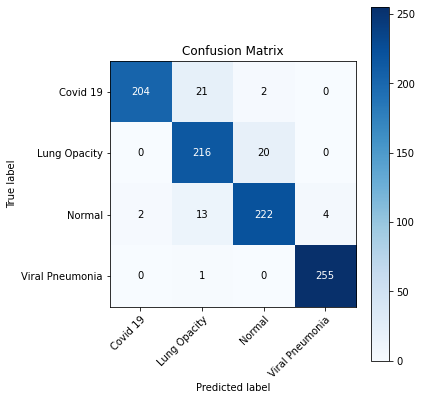

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, title='Confusion Matrix')

Normalized
--

Confusion Matrix - Normalized


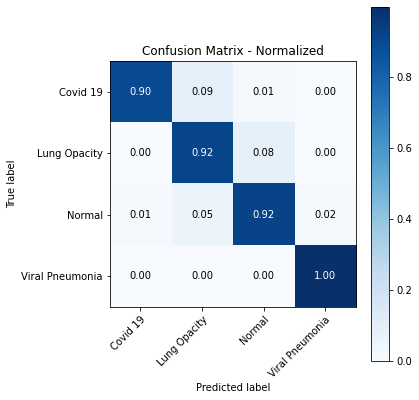

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

Performace Matricse
--

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_true, Y_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_true, Y_pred, Classes)

Accuracy: 0.9344
Precision: 0.9367
Recall: 0.9344
F1 Score: 0.9348

Report:
                 precision    recall  f1-score   support

       Covid 19       0.99      0.90      0.94       227
   Lung Opacity       0.86      0.92      0.89       236
         Normal       0.91      0.92      0.92       241
Viral Pneumonia       0.98      1.00      0.99       256

       accuracy                           0.93       960
      macro avg       0.94      0.93      0.93       960
   weighted avg       0.94      0.93      0.93       960



ROC AUC score: 0.9554796627101614


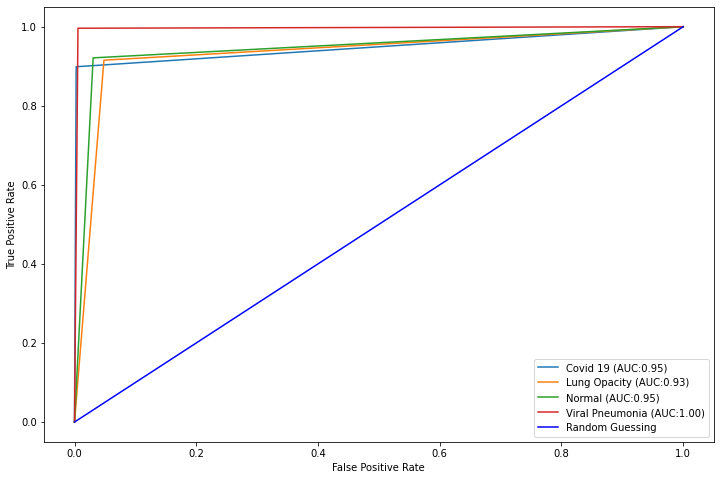

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Random Forest as Classfier of ResNet50
--

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-05-performance-0.92-0.36.hdf5')

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
new_rf_model= tf.keras.models.Model(inputs=new_model.input, outputs=new_model.layers[-4].output)

In [ ]:
new_rf_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
features_extractor = new_rf_model.predict(X_train)

In [ ]:
features = features_extractor.reshape(features_extractor.shape[0], -1)

In [ ]:
X_rf = features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
RF_model.fit(X_rf, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
test_features_extractor = new_rf_model.predict(X_test)

In [ ]:
X_test_rf = test_features_extractor.reshape(test_features_extractor.shape[0], -1)

In [ ]:
RF_pred = RF_model.predict(X_test_rf)

In [ ]:
from sklearn import metrics
Acc = metrics.accuracy_score(Y_test, RF_pred)
print(Acc)

0.9333333333333333


In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_test, RF_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_test, RF_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Confusion Matrix


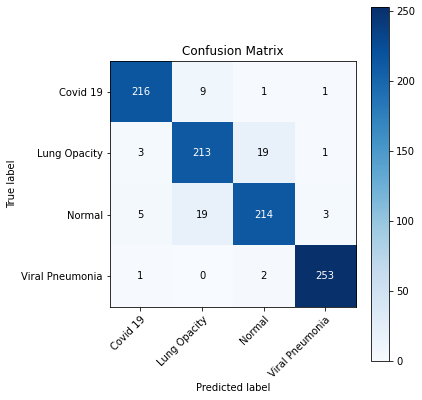

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_test, RF_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, title='Confusion Matrix')

Confusion Matrix - Normalized


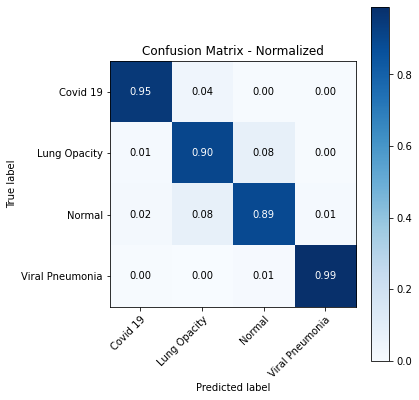

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_test, RF_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_test, RF_pred, Classes)

Accuracy: 0.9333
Precision: 0.9334
Recall: 0.9333
F1 Score: 0.9333

Report:
                 precision    recall  f1-score   support

       Covid 19       0.96      0.95      0.96       227
   Lung Opacity       0.88      0.90      0.89       236
         Normal       0.91      0.89      0.90       241
Viral Pneumonia       0.98      0.99      0.98       256

       accuracy                           0.93       960
      macro avg       0.93      0.93      0.93       960
   weighted avg       0.93      0.93      0.93       960



ROC AUC score: 0.9552099513789104


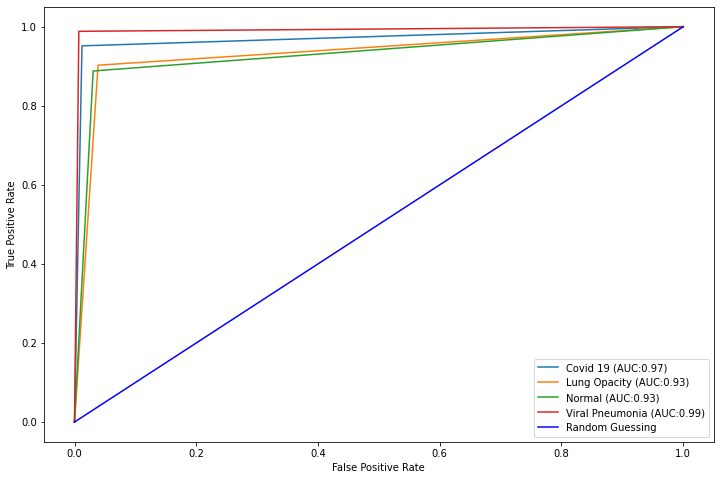

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, RF_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Random Forest without CNN as Features Extractor
--

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/ResNet50/model-ResNet50-v3-05-performance-0.92-0.36.hdf5')

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
no_cnn_model= tf.keras.models.Model(inputs=new_model.input, outputs=new_model.input)

In [ ]:
no_cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_fe = no_cnn_model.predict(X_train)

In [ ]:
X_no_CNN = X_fe.reshape(X_fe.shape[0], -1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
RF_model.fit(X_no_CNN, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
test_features_no_CNN = no_cnn_model.predict(X_test)

In [ ]:
X_test_no_CNN = test_features_no_CNN.reshape(test_features_no_CNN.shape[0], -1)

In [ ]:
RF_pred_no_CNN = RF_model.predict(X_test_no_CNN)

In [ ]:
from sklearn import metrics
Acc = metrics.accuracy_score(Y_test, RF_pred_no_CNN)
print(Acc)

0.79375


In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_test, RF_pred_no_CNN)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Confusion Matrix


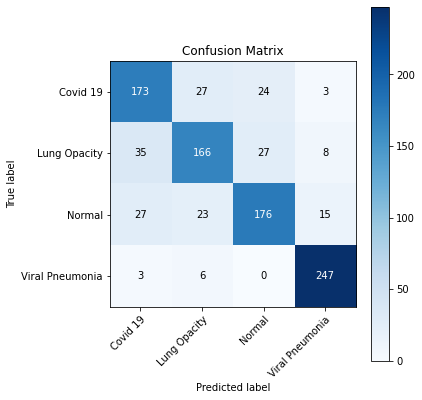

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_test, RF_pred_no_CNN)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes = Classes, title='Confusion Matrix')

Confusion Matrix - Normalized


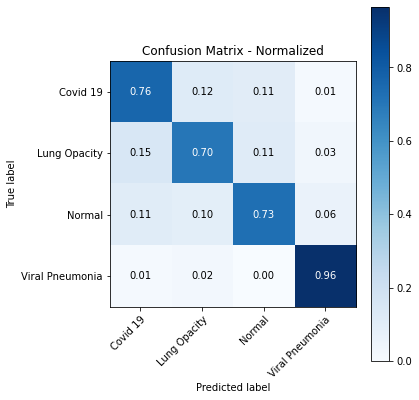

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_test, RF_pred_no_CNN)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_test, RF_pred_no_CNN, Classes)

Accuracy: 0.7938
Precision: 0.7916
Recall: 0.7938
F1 Score: 0.792

Report:
                 precision    recall  f1-score   support

       Covid 19       0.73      0.76      0.74       227
   Lung Opacity       0.75      0.70      0.72       236
         Normal       0.78      0.73      0.75       241
Viral Pneumonia       0.90      0.96      0.93       256

       accuracy                           0.79       960
      macro avg       0.79      0.79      0.79       960
   weighted avg       0.79      0.79      0.79       960



ROC AUC score: 0.8608437711124022


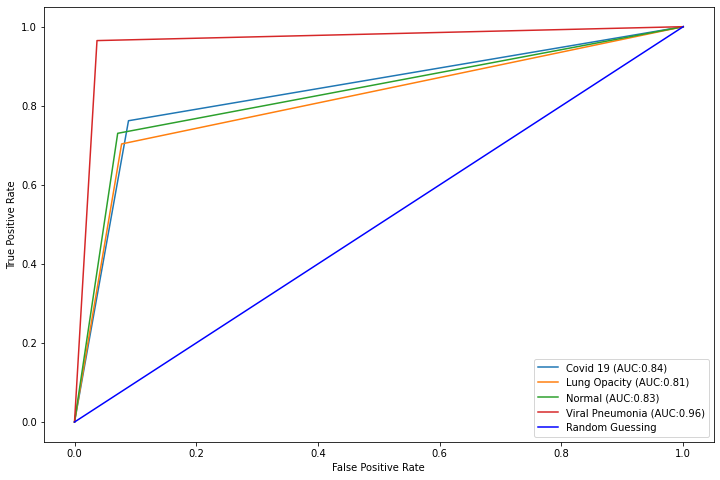

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, RF_pred_no_CNN))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()